In [10]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain, permutations
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import os

from pandas_datareader import fred
import yfinance as yf
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank, select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def adf_test_summary(ser):
    # ADF H0: there is a unit root

    specs = {'constant': 'c', 'constant trend': 'ct', 'constant ltend, qtrend': 'ctt', 'none': 'n'}
    results = {}

    for pretty, spec in specs.items():
        adf, pval, ulag, nobs, cval, icb = adfuller(ser, regression=spec)
        keys = ['adf-stat', 'p-value', 'lags', 'obs', *cval.keys(), 'inf crit']
        res = [adf, pval, ulag, nobs, *cval.values(), icb]
        results[pretty] = dict(zip(keys, res))

    if ser.name is not None:
        title = ser.name.upper()
    else:
        title = ''

    print('-' * 77)
    print(f'ADF Test {title}: H0 there is a unit root')
    print('-' * 77)
    print(pd.DataFrame(results).transpose().round(3).iloc[:, :-1])
    print('\n')

    pass


from io import StringIO
import sys


class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


def plot_df(df, n_cols: int = 3, fig_size: tuple = (5, 2)):
    n_cols = min(n_cols, df.shape[1])
    rows = int(np.ceil(df.shape[1] / n_cols))

    fig, axes = plt.subplots(rows, n_cols, figsize=(n_cols * fig_size[0], rows * fig_size[1]))
    for i, ax in enumerate(axes.reshape(-1)):
        if i > df.shape[1] - 1: continue
        ax.plot(df.iloc[:, i].dropna())
        ax.set_title(df.iloc[:, i].name)

    plt.tight_layout()
    return fig, axes


### Collecting the data

In [11]:
start, end = datetime(2021, 1, 1), datetime(2023, 10, 31)

In [12]:
reader = fred.FredReader(['CPIAUCNS', 'GDPC1', 'DCOILBRENTEU', 'DGS1', 'DGS10', 'DFII10', 'DGS5', 'DGS3MO', 'DGS6MO', 'IR'], start, end)
raw_data = reader.read()

raw_data.rename(columns={
    'CPIAUCNS': 'cpi',
    'DCOILBRENTEU': 'brent',
    'GDPC1': 'gdp',
    'DGS10': 'ust10',
    'DGS1': 'ust1',
    'DGS3MO': 'ust3m',
    'DGS6MO': 'ust6m',
    'DGS5': 'ust5',
    'IR': 'cpi_ix',
    'DFII10': 'usti10',
}, inplace=True)
raw_data.index.name = 'date'

_data = yf.download(tickers = "^GSPC", start=start, end=end)
_data.index.name = 'date'
raw_data = raw_data.join(_data['Close'].rename('sp500'), how='left')

raw_data = raw_data.asfreq('D')

raw_data['bei'] = raw_data['ust10'] - raw_data['usti10']
raw_data = raw_data[['sp500', 'bei', 'ust1', 'ust5', 'brent']].copy()

[*********************100%%**********************]  1 of 1 completed


In [13]:
week_data = raw_data.asfreq('W-Fri').copy()

In [14]:
data = week_data.copy()

# Application 1

In [15]:
week_data.describe()

,sp500,bei,ust1,ust5,brent
count,143.000000,144.000000,144.000000,144.000000,144.000000
mean,4196.287628,2.392917,2.530486,2.550000,85.230417
std,274.999580,0.184603,2.187026,1.430233,16.163175
min,3583.070068,2.060000,0.040000,0.440000,54.800000
25%,3967.690063,2.267500,0.097500,0.927500,74.497500
50%,4185.470215,2.360000,2.380000,2.930000,82.635000
75%,4425.245117,2.472500,4.742500,3.875000,94.075000
max,4766.180176,2.980000,5.460000,4.860000,127.440000


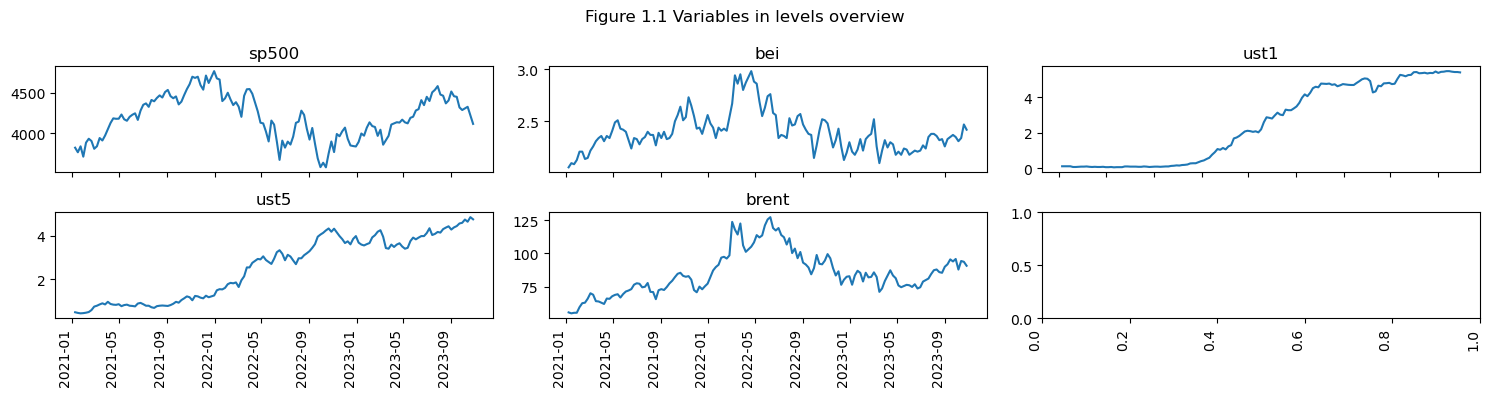

In [16]:
fig, axes = plot_df(week_data)
fig.suptitle('Figure 1.1 Variables in levels overview')
fig.autofmt_xdate(rotation=90)
fig.tight_layout()

Figure 1.1 shows the evolution of the time series across the horizon we are considering. We are considering the post COVID-19 era, looking at weekly data from 2021-01-01 to 2023-10-20, nearly present day. This gives us a total of 143 weeks. Observation of the time series suggests presence of a unit root. A time series is said to have a unit root and be non-stationary if the root of its characteristic equation is outside of the unit circle. For example, the series $y_t = α_1 y_{t-1} + ε_t$ gives $Δy_t = (m - α_1) y_{t-1} + ε_t$ and is non-stationary if $(m - α_1) = 0$, because the root is $m = 1$ which is on the unit circle. If $α_1 < 1$, the series would be stationary because the root lies inside the unit circle. The most common test for this is the Dickey-Fuller test which we perform on each series. 

We see that the S&P500 experienced a downward trend in early 2022, responding to the high inflation and the rate increases of the Federal Reserve. The series is evidently non-stationary. There does not appear to be seasonality or structural breaks in this figure, but we investigate these hypotheses in the following section. 

BEI is the break-even inflation rate. It is the difference between the market yield on a US treasury 10-year constant maturity security quoted on an investment basis (DGS10) and the same indicator but inflation indexed. It is therefore the difference between the nominal yield on the security and the real yield on the same security. BEI then represents the expectation of inflation. If BEI is higher than the actual rate of inflation, then an inflation linked investment will underperform. BEI is also clearly non-stationary, and peaks towards mid-2022, around the same time as the dip in the S&P500. Both are likely caused by the same reasons. The stubborness of inflation following COVID led to the BEI, or inflation expectation, increasing for obvious reasons. The time series tapers towards the lower-bound as we near the end of the sample and as the Central Banks begin to control inflaton better. The volatility also decreases as we near present day, suggesting more stability in the macroeconomy and financial markets.

Ust1 is the market yield on the US treasury 1-year security (DGS1) and ust5 is the same indicator but for a 5-year maturity bond (DGS5). The difference between the two gives an indication of the yield curve. The yield curve plots yields against the different maturity lengths. A upward sloping yield curve would have the 5-year bond yield exceeding the 1-year bond yield, and vice-versa for an inverted yield curve. Both tend to move in tandem, but where they overlap or one exceeds the other is where we see an inversion of the yield curve. An upward trend of DGS1 and DSG5, as observed in early 2022 indicates a tightening of monetary policy and rising interest rates. This will the central banks responding to inflation. Neither time series is stationary and they show a clear upward trend towards the end of the sample.

Brent is the leading price indicator of oil. It is important to include this as a time series because the price of oil is an  indicator of the costs of production in an economy. Oil is a key input in all transportation and manufactured goods, so an increase in the Brent oil price can stimulate inflationary pressure in an economy. Naturally, the brent price seems to follow the BEI. Both indicators are related positively to the inflation rate so it makes sense that they move in tandem. An additional point to note is that neither is stationary. 

## With stationarity


Visual examination rejects the presence of a unit root, but we formally test for stationarity in this section. We perform the Augmented Dickey-Fuller (ADF) test. We test the null hypothesis, $H_0$ that there is a unit root (the series is non-stationary) against three alternative hypotheses, $H_1$, sequentially. We test against the alternative hypothesis that the series is stationary with a constant, stationary around a linear trend with a constant, stationary around a linear trend and quadratic trend with a constant, and finally stationary with no constant.

The ADF test is applied to the model $Δy_t = α + βt +γy_{t-1}+ δ_1 Δy_{t-1} + ... + δ_{p-1}Δy_{t-p+1}+ε_t$ with p being the order of the autoregressive process determined by the Bayesian Information Criterion (BIC). The unit root null hypothesis is that $γ=0$ and the alternative is that $γ<0$.

For the S&P500, the null hypothesis cannot be rejected against any of the alternative hypotheses. We fail to reject the null hypothesis when the p-value is larger than 0.05 (for 95% confidence) and larger than 0.01 (for 99% confidence) This means that the S&P500 weekly averaged closing price is likely a non-stationary series. For the BEI the results are slightly less clear cut. Visual examination suggests non-stationarity and we cannot reject the null hypothesis with >99% confidence under any of the alternative hypotheses, but the p-value for the constant alternative hypothesis is significant at the 95% level. This suggests that the series is stationary with a constant with >95% confidence. We are sceptical about this rejection of the null hypothesis because visual examination of the series suggests there is high volatility but the acceptance of the hypothesis that there is no correlation with past values of the series looks to be incorrect.

For the yield on the 1-year and 5-year maturity bonds, the null hypothesis of there being a unit root cannot be rejected against any alternative hypotheses. This is consistent with our visual examination. The same goes for the brent oil price: we cannot reject the null hypothesis of their being a unit root. So far, we classify all of the time series as non-stationary so we move to first-differences and log transformations.

In [17]:
with Capturing() as output:
    for col in data:
        if 'log' not in col:
            adf_test_summary(data[col].dropna())

[print(i) for i in output];

-----------------------------------------------------------------------------
ADF Test SP500: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -2.387    0.145   0.0  142.0 -3.477 -2.882 -2.578
constant trend            -2.395    0.382   0.0  142.0 -4.024 -3.442 -3.145
constant ltend, qtrend    -2.399    0.626   0.0  142.0 -4.455 -3.875 -3.579
none                       0.092    0.714   0.0  142.0 -2.582 -1.943 -1.615


-----------------------------------------------------------------------------
ADF Test BEI: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -3.298    0.015   0.0  143.0 -3.477 -2.882 -2.578
constant trend            -3.369    0.056   0.0  143.0 -4.024 -3.442 -3.145


In [18]:
data_diff = data.copy()
data_diff['sp500'] = np.log(data_diff.sp500)
data_diff['brent'] = np.log(data_diff.brent)
data_diff = data.diff()

In [19]:
data_diff.describe()

,sp500,bei,ust1,ust5,brent
count,138.000000,140.000000,140.000000,140.000000,140.000000
mean,1.312031,0.002143,0.035286,0.031071,0.179214
std,97.749741,0.087588,0.112002,0.140532,4.828003
min,-264.910156,-0.260000,-0.640000,-0.520000,-16.540000
25%,-58.632446,-0.050000,-0.010000,-0.042500,-2.092500
50%,1.899902,0.010000,0.010000,0.040000,0.695000
75%,64.799927,0.060000,0.070000,0.112500,2.915000
max,258.810059,0.270000,0.400000,0.410000,25.300000


First differences are calculated with   diff$y_t = Δy_t = y_t - y_{t-1}$. For the S&P500 and the Brent oil price, the natural logarithm is applied to the prices before differencing to give us log returns: $r_t = p_t - p_{t-1} = log(P_t) - log(P_t-1) = log(\frac{P_t}{P_{t-1}})$. It is important to induce stationarity in integrated series because non-stationary series can lead to spurious regressions. When two variables are trending over time, a regression of one on the other could have a high $R^2$ even if the two variables are unrelated (Brooks - Introductory Econometrics for finance). When we induce stationarity the two variables are generated as independent random series and the coefficient would not be expected to be significantly different from 0. Visual inspection of the time series in Figure 1.2 gives us much more confidence that we are dealing with stationary series, and in many ways the series are more informative. The volatility for the S&P500, BEI and treasury bill yields is fairly stable but we do see a big spike in early 2022 which coincides with the Russian invasion of Ukraine, suggesting presence of a structural break. A structural break is where there is a significant change in the underlying data generating process and dummy variables should be included to reflect this.

We now perform the same ADF test, with the same null hypothesis of there being a unit root, and the same sequentially estimated equations of the alternative hypotheses. In every case, the p-values are 0.0 allowing us to reject the null hypothesis with >99% confidence every time. This means that the first differences of the time series are stationary and allows us to conclude that the raw data was integrated of order 1, I(1).

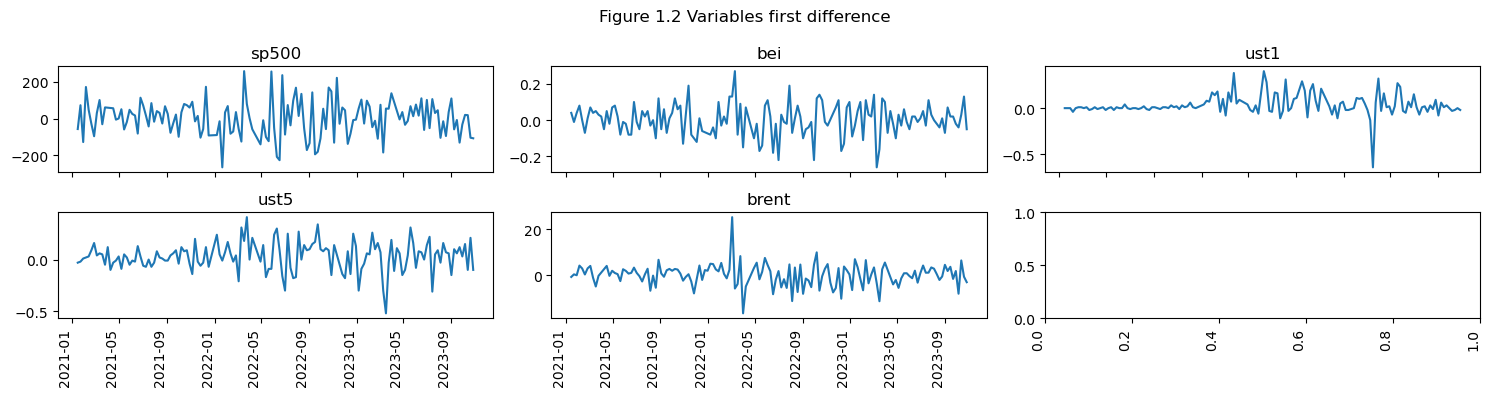

In [20]:
fig, axes = plot_df(data_diff)
fig.suptitle('Figure 1.2 Variables first difference')
fig.autofmt_xdate(rotation=90)
fig.tight_layout()

In [21]:
with Capturing() as output:
    for col in data_diff:
        if 'log' not in col:
            adf_test_summary(data_diff[col].dropna())

[print(i) for i in output];

-----------------------------------------------------------------------------
ADF Test SP500: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                 -12.653      0.0   0.0  137.0 -3.479 -2.883 -2.578
constant trend           -12.634      0.0   0.0  137.0 -4.026 -3.443 -3.146
constant ltend, qtrend   -12.610      0.0   0.0  137.0 -4.458 -3.876 -3.580
none                     -12.696      0.0   0.0  137.0 -2.582 -1.943 -1.615


-----------------------------------------------------------------------------
ADF Test BEI: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                 -12.081      0.0   0.0  139.0 -3.478 -2.883 -2.578
constant trend           -12.041      0.0   0.0  139.0 -4.025 -3.443 -3.146


## Seasonality

Following from identifying the first differenced time series as stationary, we can attempt to identify seasonality in the data. Seasonality is where the dependent variable contains a seasonal or cyclical pattern where certain features periodically occur (Brooks, 2019). An example of seasonality in time series data would be the peak in retail sales around christmas time. Seasonality and cyclicality is likely to lead to a positively autocorrelated residual structure that is cyclical in shape unless the seasonal patterns are captured by the model (Brooks, 2019). The existence of seasonalty in time series could become apparent if there is greater volatility at one period than another, for example. Seasonality is important to address because it could be that the time series is characterised by two different equations, undergoing regime shifts, for certain months or quarters of the year.

We test for both monthly and quarterly seasonalities separately using 11 monthly dummies (not 12 to avoid perfect collinearity with the constant- the 'dummy variable trap') and 3 quarterly dummies. An ordinary least squares model is estimated for the time series, regressed on the monthly and quarterly dummies. The statistical significance of the coefficients are evaluated and any significant coefficients would indicate the existence of seasonality. 

There is no significant cyclicality indicated in the stationary time series of S&P500, BEI or the Brent. However, there is evidence of quarterly cyclicality in the series for the 1-year and 5-year maturity treasury bond yields. The residuals from this OLS are the cyclical components of the time series.

In [22]:
month = [i.month for i in data_diff.index]
quarter = [int(np.ceil(i.month / 3)) for i in data_diff.index]

q_dummies = pd.get_dummies(quarter, prefix='quarter', drop_first=True)
q_dummies.set_index(data_diff.index, inplace=True)

m_dummies = pd.get_dummies(month, prefix='month', drop_first=True)
m_dummies.set_index(data_diff.index, inplace=True)

In [23]:
betas_q, betas_m = {}, {}
resid_q, resid_m = {}, {}
for col in data_diff:
    _ = data_diff[[col]].join(q_dummies).dropna().copy()
    ols = OLS(_[col], _.drop(col, axis=1)).fit()
    betas_q[col] = ols.pvalues
    resid_q[col] = ols.resid
    
    _ = data_diff[[col]].join(m_dummies).dropna().copy()
    ols = OLS(_[col], _.drop(col, axis=1)).fit()
    betas_m[col] = ols.pvalues
    resid_m[col] = ols.resid

In [24]:
betas_q = pd.DataFrame(betas_q)
betas_m = pd.DataFrame(betas_m)

In [25]:
betas_q

,sp500,bei,ust1,ust5,brent
quarter_2,0.929832,0.261019,0.015319,0.228206,0.790321
quarter_3,0.614726,0.613274,0.079908,0.122926,0.842011
quarter_4,0.639721,0.282483,0.167833,0.389285,0.674555


In [26]:
betas_m

,sp500,bei,ust1,ust5,brent
month_2,0.881855,0.574701,0.067675,0.021817,0.387047
month_3,0.196531,0.088398,0.790074,0.691051,0.284032
month_4,0.692506,0.409586,0.406395,0.819989,0.185388
month_5,0.803170,0.530618,0.365200,0.787989,0.575743
month_6,0.833033,0.611825,0.015651,0.109143,0.934802
month_7,0.209389,0.561503,0.815593,0.207562,0.767564
month_8,0.692929,0.947333,0.258112,0.076983,0.378702
month_9,0.083168,0.170373,0.094872,0.022879,0.853643
month_10,0.408250,0.058658,0.227507,0.321208,0.720909
month_11,0.682286,0.708721,0.319411,0.953336,0.113357


In [27]:
cols_seasonal = []
for col in ['ust1', 'ust5']:
    cols_seasonal.append(f'{col}_cyc')
    data_diff[f'{col}_cyc'] = resid_q[col]

## ARMA

An Autoregressive Moving Average Model (ARMA). ARMA models combine the autoregressive and moving average models into a form so that the number of parameters used is kept small. A time series $r_t$ follows an ARMA(p,q) model if it satisfies:
$$
r_t = \phi_0 + Σ^p_{i=1}\phi_ir_{t-i} + a_t - Σ_{i=1}^qθ_ia_{t-1}
$$
Where $a_t$ is white noise and p and q are non-negative integers (Analysis of financial time series). The autoregressive part of an ARMA model incorporates lagged values of the dependent variable as explanatory variable. The moving average part of an ARMA model accounts for the part of $r_t$ that is a weighted average of the past shocks $a_t$ up to lag $q$. As time goes on, the weighted average 'moves', hence the term moving average.

The autocorrelation functions and partial autocorrelation functions are not informative in determining the order of the ARMA model (Tsay, 2005). We plot the ACF for the cyclical component of the 1-year and 5-year maturity treasury bond yields, and then follow up with specification of the model using the Bayesian Information Criterion.

As can be seen in Figure 1.3, the ACF and PACF for the 5-year bond does not indicate any autocorrelations or partial autocorrelations different from 0, other than a stray at the 12th lag which is small and negative. None of the earlier lags are significantly different from zero.

For the 1-year bond, the first lag appears to be significant suggesting an ARMA model may be appropriate. Again, we see a stray coefficient escape the confidence interval at the 13th lag.

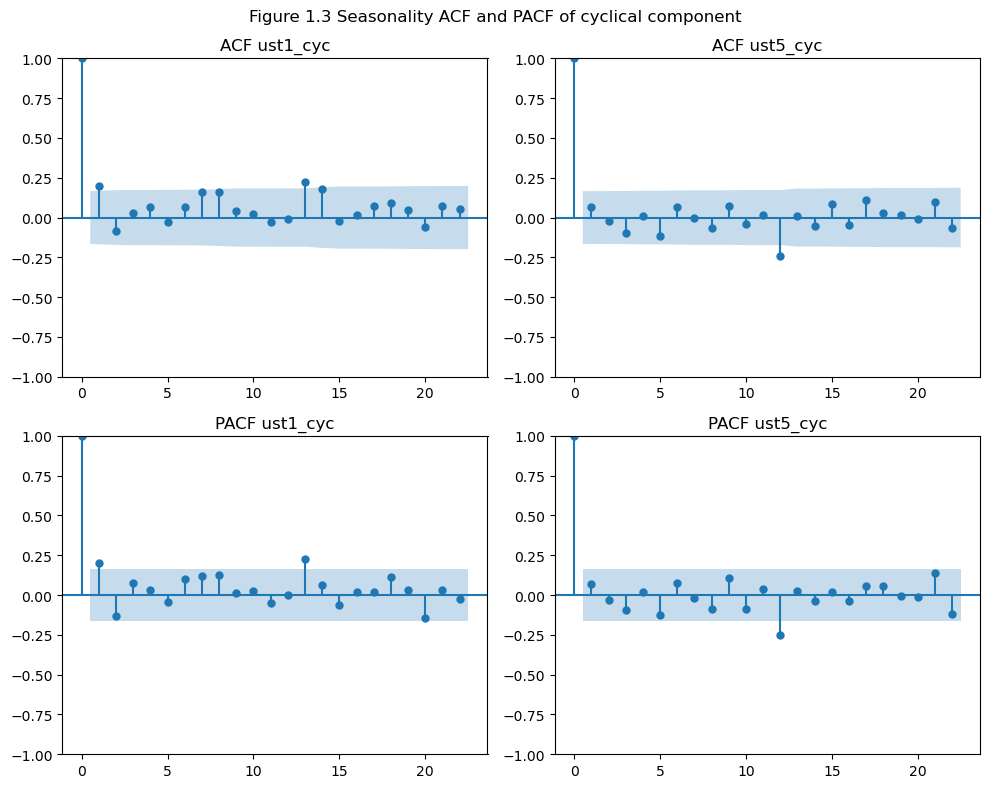

In [28]:
fig, ax = plt.subplots(2, data_diff[cols_seasonal].shape[1], figsize=(5 * data_diff[cols_seasonal].shape[1], 8))
for i, col in enumerate(data_diff[cols_seasonal]):
    plot_acf(data_diff[col].dropna(), ax=ax[0, i])
    ax[0, i].set_title(f'ACF {col}')
    
    plot_pacf(data_diff[col].dropna(), ax=ax[1, i])
    ax[1, i].set_title(f'PACF {col}')

fig.suptitle('Figure 1.3 Seasonality ACF and PACF of cyclical component')
fig.tight_layout()

In [29]:
arma_search_space = [*permutations(range(1, 3), 2)]

Specification of an ARMA could involve Tsay and Tiao's (1984) extended autocorrelation function, but as per the instructions for this project, we use the information criterion. The BIC is one of the most commonly used criteria for selecting lag length for autoregressive models. The penalty for including additional parameters for the BIC tends to be higher than that of the Akaike Information Criterion, and tends to select a lower lag length when the sample size is moderate or large (Analysis of financial time series).

The formila for the BIC is $BIC(l) = ln(\tildeσ^2_l)+\frac{lln(T)}{T}$ where $ln(T)$ is the penalty term for each parameter used. The penalty for the AIC is 2. $\tildeσ^2_l$ is the maximum liklihood estimate of the variance of a_t and $T$ is the sample size.

Employing the BIC indicates that the best ARMA models to estimate for the cyclical components of the 1-year and 5-year treasury bills is ARMA(2,1) and ARMA(1,2) respectively.

ust1_cyc min bic arma (2, 1)
ust5_cyc min bic arma (1, 2)


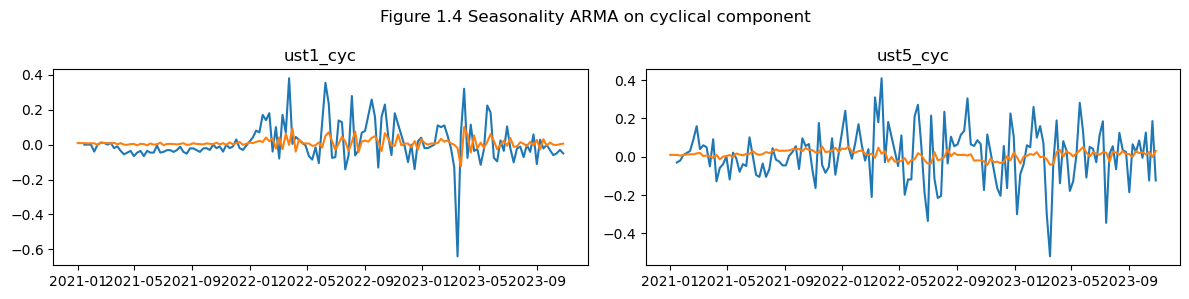

In [30]:
fig, ax = plt.subplots(
    int(np.min([2, np.ceil(len(cols_seasonal) / 2)])), 
    len(cols_seasonal), 
    figsize=(6 * len(cols_seasonal), 3)
)
armas = {}
for idx, col in enumerate(cols_seasonal):
    
    _armas = {}
    for i, per in enumerate(arma_search_space):
        _armas[i] = ARIMA(data_diff[col], order=(per[0], 0, per[1])).fit()
        
    d = {idx: obj.bic for idx, obj in _armas.items()}
    id_min = min(d, key=d.get)
    print(col, 'min bic arma', arma_search_space[id_min])

    ax[idx].plot(data_diff[col].dropna())
    ax[idx].plot(_armas[id_min].fittedvalues)
    ax[idx].set_title(col)

    armas = _armas[id_min]
    
fig.suptitle('Figure 1.4 Seasonality ARMA on cyclical component')
fig.tight_layout()

Figure 1.4 shows the ARMA models estimated for the cyclical part. The means of each series are well estimated, with the esimtated time series cutting through the centre of the series and neither showing a trend away from the actual cyclical values. Nevertheless, the ARMA models cannot capture the full volatility of the cyclical parts of the 1 and 5 year maturity bond yields (first difference). Particularly for the 1-year bond, the estimated series does show movements in the direction of the actual values, but cannot capture fully the dip in early 2023 for example. This suggests that an ARCH or GARCH model would be more appropriate.

In [31]:
from statsmodels.tsa.arima.model import ARIMA

data_diff_cleaned = data_diff.dropna()

order = (2, 0, 1)
model_arma = ARIMA(data_diff_cleaned['ust1_cyc'], order=order).fit()

print(model_arma.summary())


                               SARIMAX Results                                
Dep. Variable:               ust1_cyc   No. Observations:                  136
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 108.618
Date:                Mon, 11 Dec 2023   AIC                           -207.235
Time:                        11:05:43   BIC                           -192.672
Sample:                             0   HQIC                          -201.317
                                - 136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.011      0.834      0.404      -0.012       0.030
ar.L1          0.0700      0.539      0.130      0.897      -0.985       1.126
ar.L2         -0.1286      0.155     -0.830      0.4

Estimation of the ARMA model for the cyclical part of the 1-year yields:
$$
\hat{y_t} = 0.0088 + 0.0700 \hat{y_{t-1}} - 0.1286 \hat{y_{t-2}} + 0.1857\hat{ε_{t-1}} + \hat{ε_t}
$$
The coefficents do not have p-values < 0.05, suggesting they are not significantly different from 0. The null hypothesis on the coefficients is that they are equal to 0, so the high p-values prevents us from rejecting these null hypotheses. This perhaps explains some of the underfitting present in Figure 1.4. Promisingly, the Ljung-Box statistic's p-value is 0.96. This means we cannot reject the null hypothesis of the test, which posits that the correlations of the residuals are null and independently distributed. If there was serial correlation in the residuals, the model would be improperly specified.

Moving on to the ARMA(1,2) model for the 5-year treasury bond, the model is specified as:
$$
\hat{y_t} = 0.0098 - 0.7569\hat{y_{t-1}} + 0.9000\hat{ε_{t-1}} + 0.1935\hat{ε_{t-2}} + \hat{ε_t}
$$
Promisingly, the coefficients on tha variables have much lower p-values. For all coefficients, we can reject the null hypotheses that the coefficients are not significantly different from 0 in all cases with more than 99% confidence (p<0.01). This suggests this model is better specified, despite it exhibiting the same problems as the 1-year bond ARMA model in Figure 1.4. We can reach the same conclusion for the Ljung-Box test as well whih tests whether there is an absence of serial correlation in the residuals ($H_0$). The p-value is 0.75, so we cannot reject this null hypothesis which is the favourable result. 

Figure 1.X and 1.X shows the ACF anf PACF for the residuals of the residuals of the two ARMA model estimated above. Ideally, we would not observe any autocorrelation coefficients significantly different from 0. This is certaintly the case for the ARMA(2,1) model estimated for the 1-year bond. None of the autocorrelation coefficients that we estimated up to 22 lags escape the 95% significance boundary. If there was serial correlation in the residuals the standard error estimates would be incorrect and we would violate the Gauss-Markov assumptions.

For the ARMA(1,2) model for the cyclical component of the 5-year bond, the story is much the same. Indeed, there is autocorrelation coefficient for the residuals that escapes the 95% confidence boundary at the 12th lag, but the coefficient remains small. Overall, both models appear not to show autocorrelation in the residuals, based both on the ACF and PACF plots and the Ljung-Box statistics.

Estimation of the ARMA models for the cyclical components of the two series and their plots against the actual data is Figure 1.4. The ARMA models estimate the mean well, as you would expect, and generally move in the same direction as the actual time series. However, the ARMA models do not capture the volatility well. For example, the large stalagtite the 1-year bond in early 2023 is not captured. The ARMA models underfit the data.

Turning consideration to the residuals, a poorly specified ARMA model would exhibit autocorrelation in the residuals. Observation of the ACFs for both the 1-year and 5-year treasury bond cyclical components suggests no autocorrelation in the residuals. We can also consider the Ljung-Box statistic. Ljung and Box (1978) modify the Portmanteau test to increase the power in small samples. The desirable outcome from the Ljung-Box test statistic is to fail to reject the null hypothesis, suggesting the residuals are independently distributed. In the case of the 1-year bond, the p-value is 0.00 so we must reject the null that the residuals are independently distributed and accept the alternative hypothesis that the residuals exhibit serial correlation. In the case of the 5-year bond, the p-value is 0.03. We cannot reject the null at the 99% confidence level, but we can at the 95% confidence level, again suggesting serial correlation. 

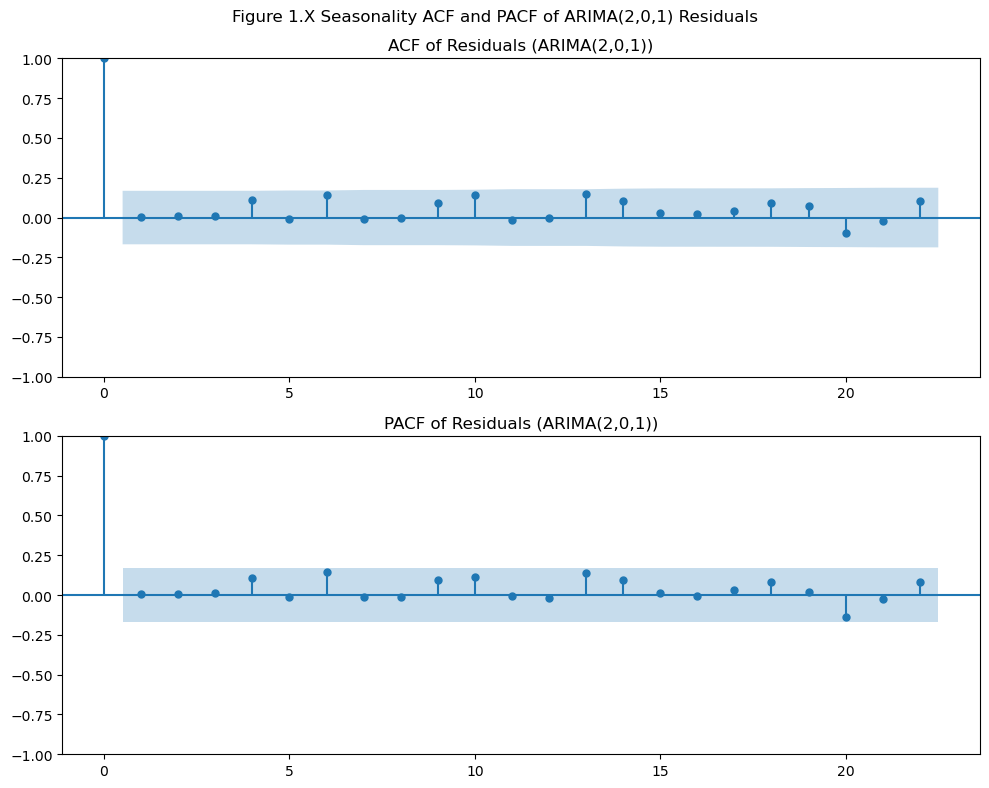

In [32]:
residuals_arma = model_arma.resid.dropna()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(residuals_arma, ax=ax[0])
ax[0].set_title('ACF of Residuals (ARIMA(2,0,1))')

plot_pacf(residuals_arma, ax=ax[1])
ax[1].set_title('PACF of Residuals (ARIMA(2,0,1))')

fig.suptitle('Figure 1.X Seasonality ACF and PACF of ARIMA(2,0,1) Residuals')
fig.tight_layout()
plt.show()

In [33]:
data_diff_cleaned = data_diff.dropna()

order = (1, 0, 2)
model_arma = ARIMA(data_diff_cleaned['ust5_cyc'], order=order).fit()

print(model_arma.summary())

                               SARIMAX Results                                
Dep. Variable:               ust5_cyc   No. Observations:                  136
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  74.486
Date:                Mon, 11 Dec 2023   AIC                           -138.971
Time:                        11:05:43   BIC                           -124.408
Sample:                             0   HQIC                          -133.053
                                - 136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.016      0.622      0.534      -0.021       0.041
ar.L1         -0.7569      0.261     -2.905      0.004      -1.268      -0.246
ma.L1          0.9000      0.261      3.444      0.0

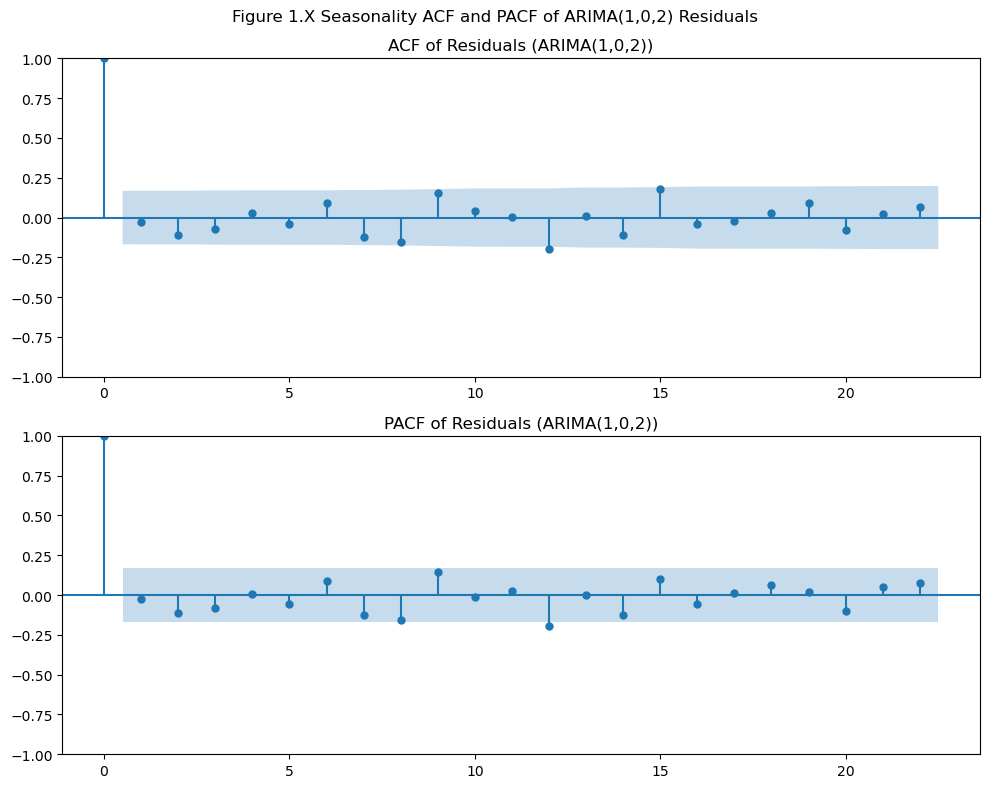

In [34]:
residuals_arma = model_arma.resid.dropna()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals_arma, ax=ax[0])
ax[0].set_title('ACF of Residuals (ARIMA(1,0,2))')
plot_pacf(residuals_arma, ax=ax[1])
ax[1].set_title('PACF of Residuals (ARIMA(1,0,2))')

fig.suptitle('Figure 1.X Seasonality ACF and PACF of ARIMA(1,0,2) Residuals')
fig.tight_layout()
plt.show()

## Applications 2&3

In [35]:
vecm_data = data.copy()

### Gets lags from VAR in levels

We employ the same data as used in the first empirical analysis, considering first the data in levels. As we saw from the ADF tests in the first section, only BEI shows signs of stationarity without first differences, but even in this case we cannot reject the ADF test's null hypothesis of presence of a unit root with 99% confidence, only 95%. Considering a VAR in levels with non-stationary data is problematic for model stability and there may also be presence of cointgeration which can lead to 'spurious regressions'.

A vector autoregressive model, VAR(p) is of the form
$$
y_t = β_0 + \sigma^p_{i=1}A_iy_{t-i} + u_t
$$
where $y_t$ is an $n x 1$ vector is interrelated variables at time t, $β_0$ is an $n x 1$ vector of constants, $A_i$ is an  $n x n$ vector of coefficients on the vectors of variables 1 to n from 1 lag to $p$ lags. It is the coefficient matrix for the ith lag. $u_t$ is an $n x 1$ vector of error terms.

We begin by determining lag length for the prospective VAR in levels of our variables: S&P500 price, break-even inflation, 1-year and 5-year maturity bond yields, and the Brent oil price. The Akaike informaton criterion, Bayesian information criterion, the final prediction error and Hannan-Quinn information criterion. The Akaike information criterion has a constant penalty for the inclusion of additional lags and tends to reccomend a choice of lag length that is larger. However, all measures reccomend a lag length of 0. This means the best specified model is a model with 0 lags making a VAR implausible. Perhaps the most likely reason for this is the presence of cointegration where there is a linear relationship between variables in the model, implying they move in the same direction. A Vector Error Correction Model is better equipped to handle cointegrating relationships in data.

To illustrate the problems with estimating a VAR with possible cointegrating relationships and non-stationary data, we estimate a VAR model with 1 lag of each of the variables.

In [36]:
varL_order = select_order(vecm_data.dropna().values, maxlags=5, deterministic='ci')
varL_order.summary()

,AIC,BIC,FPE,HQIC
0,-1.857*,-1.108*,0.1561*,-1.553*
1,-1.827,-0.5419,0.1613,-1.305
2,-1.776,0.04439,0.1704,-1.036
3,-1.630,0.7258,0.1988,-0.6727
4,-1.515,1.376,0.2257,-0.3402
5,-1.424,2.003,0.2518,-0.03149


## VAR in Levels

In [37]:
var = VAR(vecm_data.dropna()).fit()
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Dec, 2023
Time:                     11:05:44
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -1.41921
Nobs:                     141.000    HQIC:                  -1.79166
Log likelihood:          -826.066    FPE:                   0.129205
AIC:                     -2.04661    Det(Omega_mle):        0.104903
--------------------------------------------------------------------
Results for equation sp500
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const          441.929467       167.679195            2.636           0.008
L1.sp500         0.930978         0.034068           27.327           0.000
L1.bei         -49.653977        87.368035           -0.568           0.570
L1.u

This is with just one lag despite the information criteria considered suggesting no lags, and most of the coefficients on the variables have p-values greater than 0.05, preventing us from rejecting the null hypothesis that these coefficients are equal to 0. We have also provided the plots of the impulse response functions in the appendix. The evolution of most of the variables following the shocks have 95% confidence boundaries that include the horizontal y=0 axis, meaning we cannot claim the response to be different from 0. Those that do have 95% confidence boundaries that depat the y=0 line are either the recipients of the shock (which do not count) or have effects that are so small they are almost negligible.

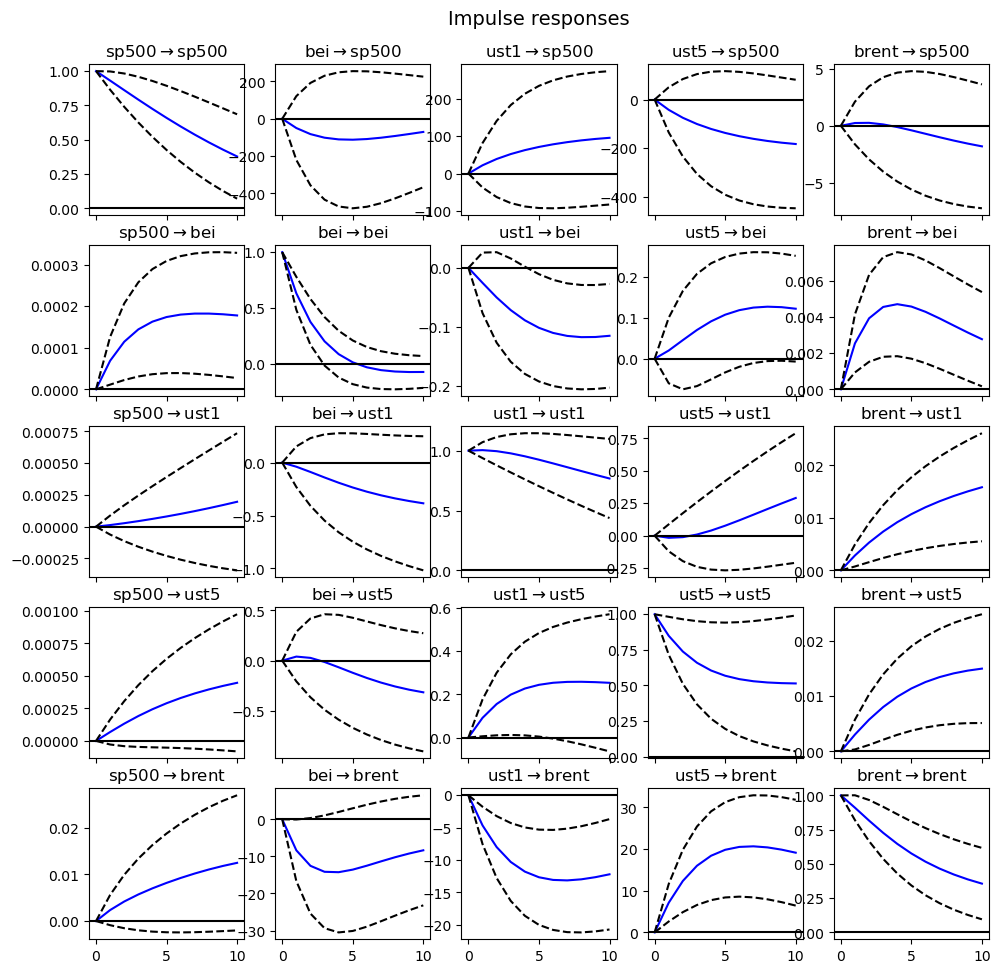

In [38]:
var.irf().plot();

In [39]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd

# Assuming 'vecm_data' is your DataFrame containing the variables sp500, brent, ust1, ust5, bei

# List of variables
variables = ['sp500', 'brent', 'ust1', 'ust5', 'bei']

# Create an empty DataFrame to store p-values
p_values_matrix = pd.DataFrame(index=variables, columns=variables)

# Iterate through pairs of variables and perform Granger causality tests
for var1 in variables:
    for var2 in variables:
        if var1 != var2:
            # Concatenate the two variables for the test
            data_for_test = pd.concat([vecm_data[var1], vecm_data[var2]], axis=1)
            data_for_test = data_for_test.dropna()
            
            # Perform Granger causality test
            results = grangercausalitytests(data_for_test, maxlag=1, verbose=False)
            
            # Extract and store the p-value
            p_value = results[1][0]['ssr_ftest'][1]
            p_values_matrix.loc[var1, var2] = p_value

# Display the matrix of p-values
print("Granger Causality P-Values Matrix:")
p_values_matrix


Granger Causality P-Values Matrix:


,sp500,brent,ust1,ust5,bei
sp500,NaN,0.068473,0.327097,0.15616,0.079233
brent,0.528696,NaN,0.615703,0.896069,0.993796
ust1,0.807459,0.00019,NaN,0.011065,0.010948
ust5,0.09594,0.11326,0.799691,NaN,0.280654
bei,0.142416,0.134395,0.128351,0.188787,NaN


We have also estimated a matrix showing the granger causality tests of the variables on each other. The Granger Causality test is the statistic that tests whether one variable has forecasting power for another variable. The null hypothesis is that the variable in the first row has no predictive power for future values of the variable in the first column. If the value shown is less than 0.05, then the null hypothesis can be rejected and we can say X granger causes Y. The only statistically significant p-value is that of BEI granger causing the 1-year bond yield. There is very likely some predictive power between these financial variables, but we must recognise that the granger test relies on I(0) or weakly stationary time series. So as a test of the VAR in levels, which should also be estimated with I(0) series, it is weak.

## VECM Model

The vector error correction model is used when there is cointegration between the variables. The 'error correction' is because last period's deviation from the long-run equilibrium price, which is the error or residual, influences the dynamics of the price evolution. To avoid ignoring potentially important long-run relationships between the variables the I(1) variables are not differenced to induce stationarity and to allow estimation of a VAR. We continue to use the variables in levels as specified in the empirical application.

A VECM is of the form:
$$ y_t = Πy_{t−k} + Γ_1Δy_{t-1} + Γ_2Δy_{t-2} + ... + Γ_{k-1}Δy_{t-(k-1)} + u_t $$

with $Π = Σ^k_{i=1}β_i$


$y_t$ contains the n variables in the first differenced form (Tsay, 2005). Π is the long-run coefficient matrix because in the equilibrium, the differenced variables are all 0. The test for cointegration of the variables $P_t$ and $D_t$ is conducted by looking at the rank of the Π coefficient matrix and its eigenvalues (Brooks, 2019). The rank of the matrix is the number of eigenvalues that are different from 0. The eigenvalues, denoted λ, are put in ascending order and if they are roots they must be less than 1 in absolute value but positive. $λ_1$ will be the largest all the way to $λ_g$ which is the smallest.

If the rank is 1, $ln(1-λ_1)$ will be negative and $ln(1-λ_i) = 0\forall i$.

The 'trace' approach that follows in this analysis uses the test-statistic 
$$
λ_{trace}(r) = -TΣ_{i=r+1}^g ln(1-\hat{λ_i})
$$

where r is the number of cointegrating vectors under the null. $λ_{trace}$ is a joint test where the null, $H_0$:number of cointegrating vectors is less than or equal to r where the alternative is larger than or equal to r. This means it is a test that starts with p eigenvalues and the largest is removed until the eigenvalues are equal to 0 and the indication of the cointegrating relationships have been exhausted (Brooks, 2019).

In [40]:
jtest = select_coint_rank(data.dropna(), 0, 15, method="trace", signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          120.9          69.82
  1   5          59.94          47.85
  2   5          33.39          29.80
  3   5          12.03          15.49
-------------------------------------


3

The trace cointegration test's nul hypothesis cannot be rejecte for the first time $H_0$ is three cointegrating relationships. This means we have three cointegrating relationships between the variables.

The maximum eigenvalue test is also employed. The null hypothesis is slightly different and tests whether the largest eigenvalue is 0 against the alternative hypothesis that the next largest eigenvalue is equal to zero. This test suggests only 1 cointegrating relationship.

In [41]:
jtest = select_coint_rank(data.dropna(), 0, 15, method="maxeig", signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          60.92          33.88
  1   2          26.56          27.59
-------------------------------------


1

We experiment with two crisis motivated structural breaks. As we have mentioned, we are using data post-COVID, but we are including boolean variables for the Russian invasion of Ukraine in 24-2-2022, and another for the Palestinian crisis in October of this year.

In [42]:
is_ukraine = [i >= datetime(2022, 2, 24) for i in vecm_data.index]
is_palestine = [i >= datetime(2023, 10, 7) for i in vecm_data.index]

vecm_data['is_ukraine'] = is_ukraine
vecm_data['is_palestine'] = is_palestine
cols_is_crisis = ['is_ukraine', 'is_palestine']
vecm_data.dropna(inplace=True)


In [43]:
vecm_data.head()

,sp500,bei,ust1,ust5,brent,is_ukraine,is_palestine
date,,,,,,,
2021-01-08,3824.679932,2.06,0.10,0.49,55.51,False,False
2021-01-15,3768.250000,2.10,0.10,0.46,54.80,False,False
2021-01-22,3841.469971,2.09,0.10,0.44,55.22,False,False
2021-01-29,3714.239990,2.13,0.10,0.45,55.25,False,False
2021-02-05,3886.830078,2.21,0.06,0.47,59.48,False,False


The vector error correction model with one lag is estimated with the crisis indicators as exogenous variables. A VECM model is appropriate here because we have confirmed the existence of at least 1 cointegration relationship, two according to the trace eigenvalue test. Error correcting models work by the deviation from the long-term equilibrium of the time series exerting a short-term effect on the evolution and causing an 'error correcting' mechanism, thereby returning the time series to its equilibrium trend. VECM estimation including the error correcting terms to account for short-run adjustments, and the cointegration equations specify the cointegrating relationships between the variables. The speed of the correction is shown by the error correction coefficients.

We saw above how cointegration exists, but with the variables in levels the lag specification tests (BIC, AIC etc) suggested 0 lags. This suggests the past values of other variables do not hold explanatory power for the other variables. It is therefore likely there may be misspecification or a lack of significance of the coefficients. Indeed, this is the case. For most of the equations, most of the coefficients have p-values greater than 0.05. This means we cannot reject the null that the coefficients are equal to 0 with 95% confidence. We see a few significant variables, like the first lag of oil price on the S&P500, or the first lag of the 5-year maturity yield on the break-even inflation rate. With respect to our crisis indicators, the Palestinian crisis has no impact distinguishable from 0 on the evolution of any of the time series (p-value > 0.05) based on the same null hypothesis as the other coefficients. However, the Ukrainian war indicator appears to be statistically significant in at at least the 95% confidence (p < 0.05) for all equations other than the S&P500. 

Turning now to the error correcting equations, the coefficient is not statistically significant for the S&P500 and the 5-year bond yield. This suggests there is no 'equilibrium returning' behaviour. Conversely, for BEI, the 1-year bond yield and the brent oil price, the coefficient on the error correcting mechanism is statistically significant, indicating this 'error correction' mechanism exists for these time series.

In [44]:
vecm = VECM(vecm_data.drop(cols_is_crisis, axis=1),
            exog=vecm_data[cols_is_crisis], 
            k_ar_diff=max(varL_order.bic, 1), 
            coint_rank=jtest.rank).fit()

print(vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sp500
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1        -74.0707     50.717     -1.460      0.144    -173.475      25.334
exog2        -56.5225     57.086     -0.990      0.322    -168.409      55.364
L1.sp500      -0.0528      0.088     -0.600      0.549      -0.225       0.120
L1.bei        44.1583    113.269      0.390      0.697    -177.846     266.162
L1.ust1       -4.3996    105.028     -0.042      0.967    -210.251     201.452
L1.ust5      -73.3444     88.124     -0.832      0.405    -246.064      99.375
L1.brent      -4.9181      1.780     -2.763      0.006      -8.406      -1.430
Det. terms outside the coint. relation & lagged endog. parameters for equation bei
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

Figure 2.3 shows the how the estimated values for the time series fit the actual data. The model appears to fit the data well, with the estimated values following closing the moving mean, as well as matching any increases in volatility. However, for all time series, and this is common with VECM estimation, there is a slight lag in the reaction of the model to the actual values suggesting weak forecasting power.

Text(0.5, 0.98, 'Figure 2.3 VECM data fit')

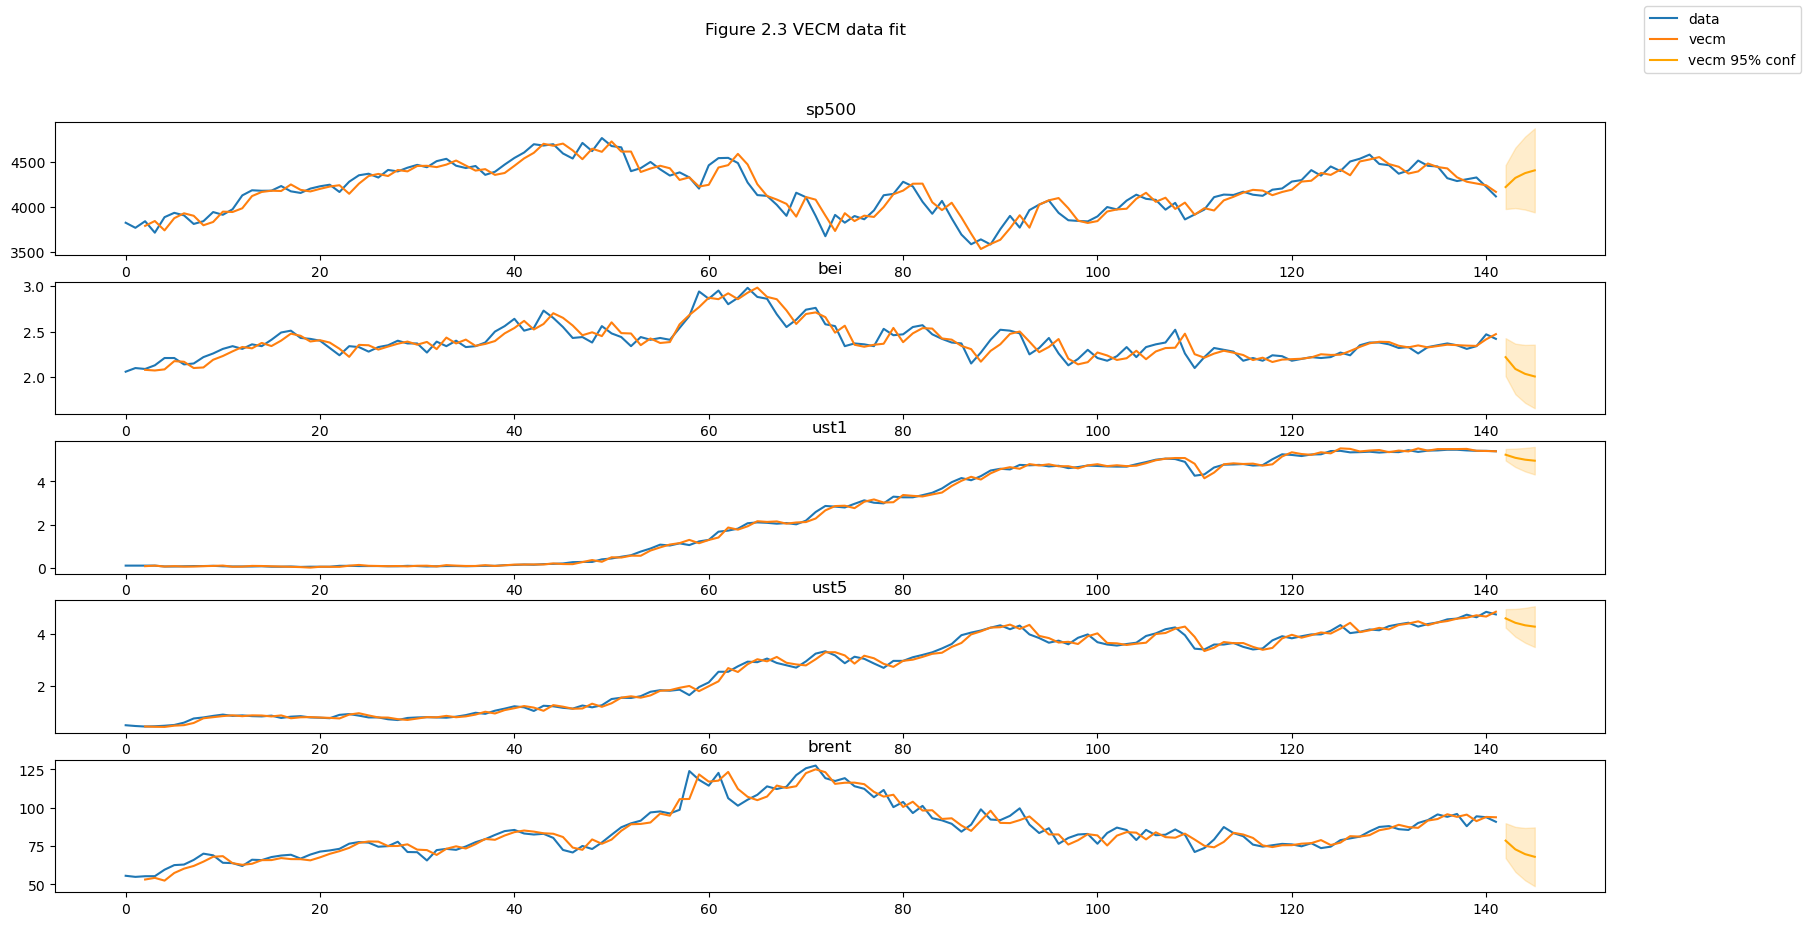

In [45]:
pred_steps = 4
pred, lower, upper = vecm.predict(pred_steps, alpha=.01, exog_fc=np.zeros((pred_steps, len(cols_is_crisis))) + False)
index = [*range(0, vecm_data.shape[0] + pred_steps)]

fig, axes = plt.subplots(vecm_data.drop(cols_is_crisis, axis=1).shape[1], 1, figsize=(20, vecm_data.drop(cols_is_crisis, axis=1).shape[1] * 2))

for idx, ax in enumerate(axes.ravel()):

    ax.set_title(vecm_data.columns[idx])
    ax.plot(index[:-pred_steps], vecm_data.iloc[:,idx].values)
    ax.plot(index[vecm.k_ar:-pred_steps], vecm.fittedvalues[:, idx], label='vecm')
    ax.plot(index[-pred_steps:], pred[:, idx], color='orange', label='vecm conf')
    ax.fill_between(index[-pred_steps:], lower[:, idx], upper[:, idx], alpha=.2, color='orange')

fig.legend(['data', 'vecm', 'vecm 95% conf'])
fig.suptitle('Figure 2.3 VECM data fit')

Turning to the impulse response functions in Figure 2.4, there are again few responses where the 95% boundary does not absorp the y=0 line. When this line is in the boundary, we cannot say with confidence that the response is different from 0. Again, even when this boundary does not include the y=0 line, the responses are extremely small in magnitude. For example consider the shock of 1 unit to the S&P500 and the effect on the 1-year treasury bond yields. For context, the bond yield is about 5% currently, and the response is between 0.0007% and  0.0001%. This is fractions of a percent. Nevertheless, considering the shape of many of the impulse responses suggests error correcting mechanisms. Many of the shocks appear sharp, then die away as time passes, showing the return to the equilibrium value. Some have more lasting effects, like the shocks on the treasury bond yields.

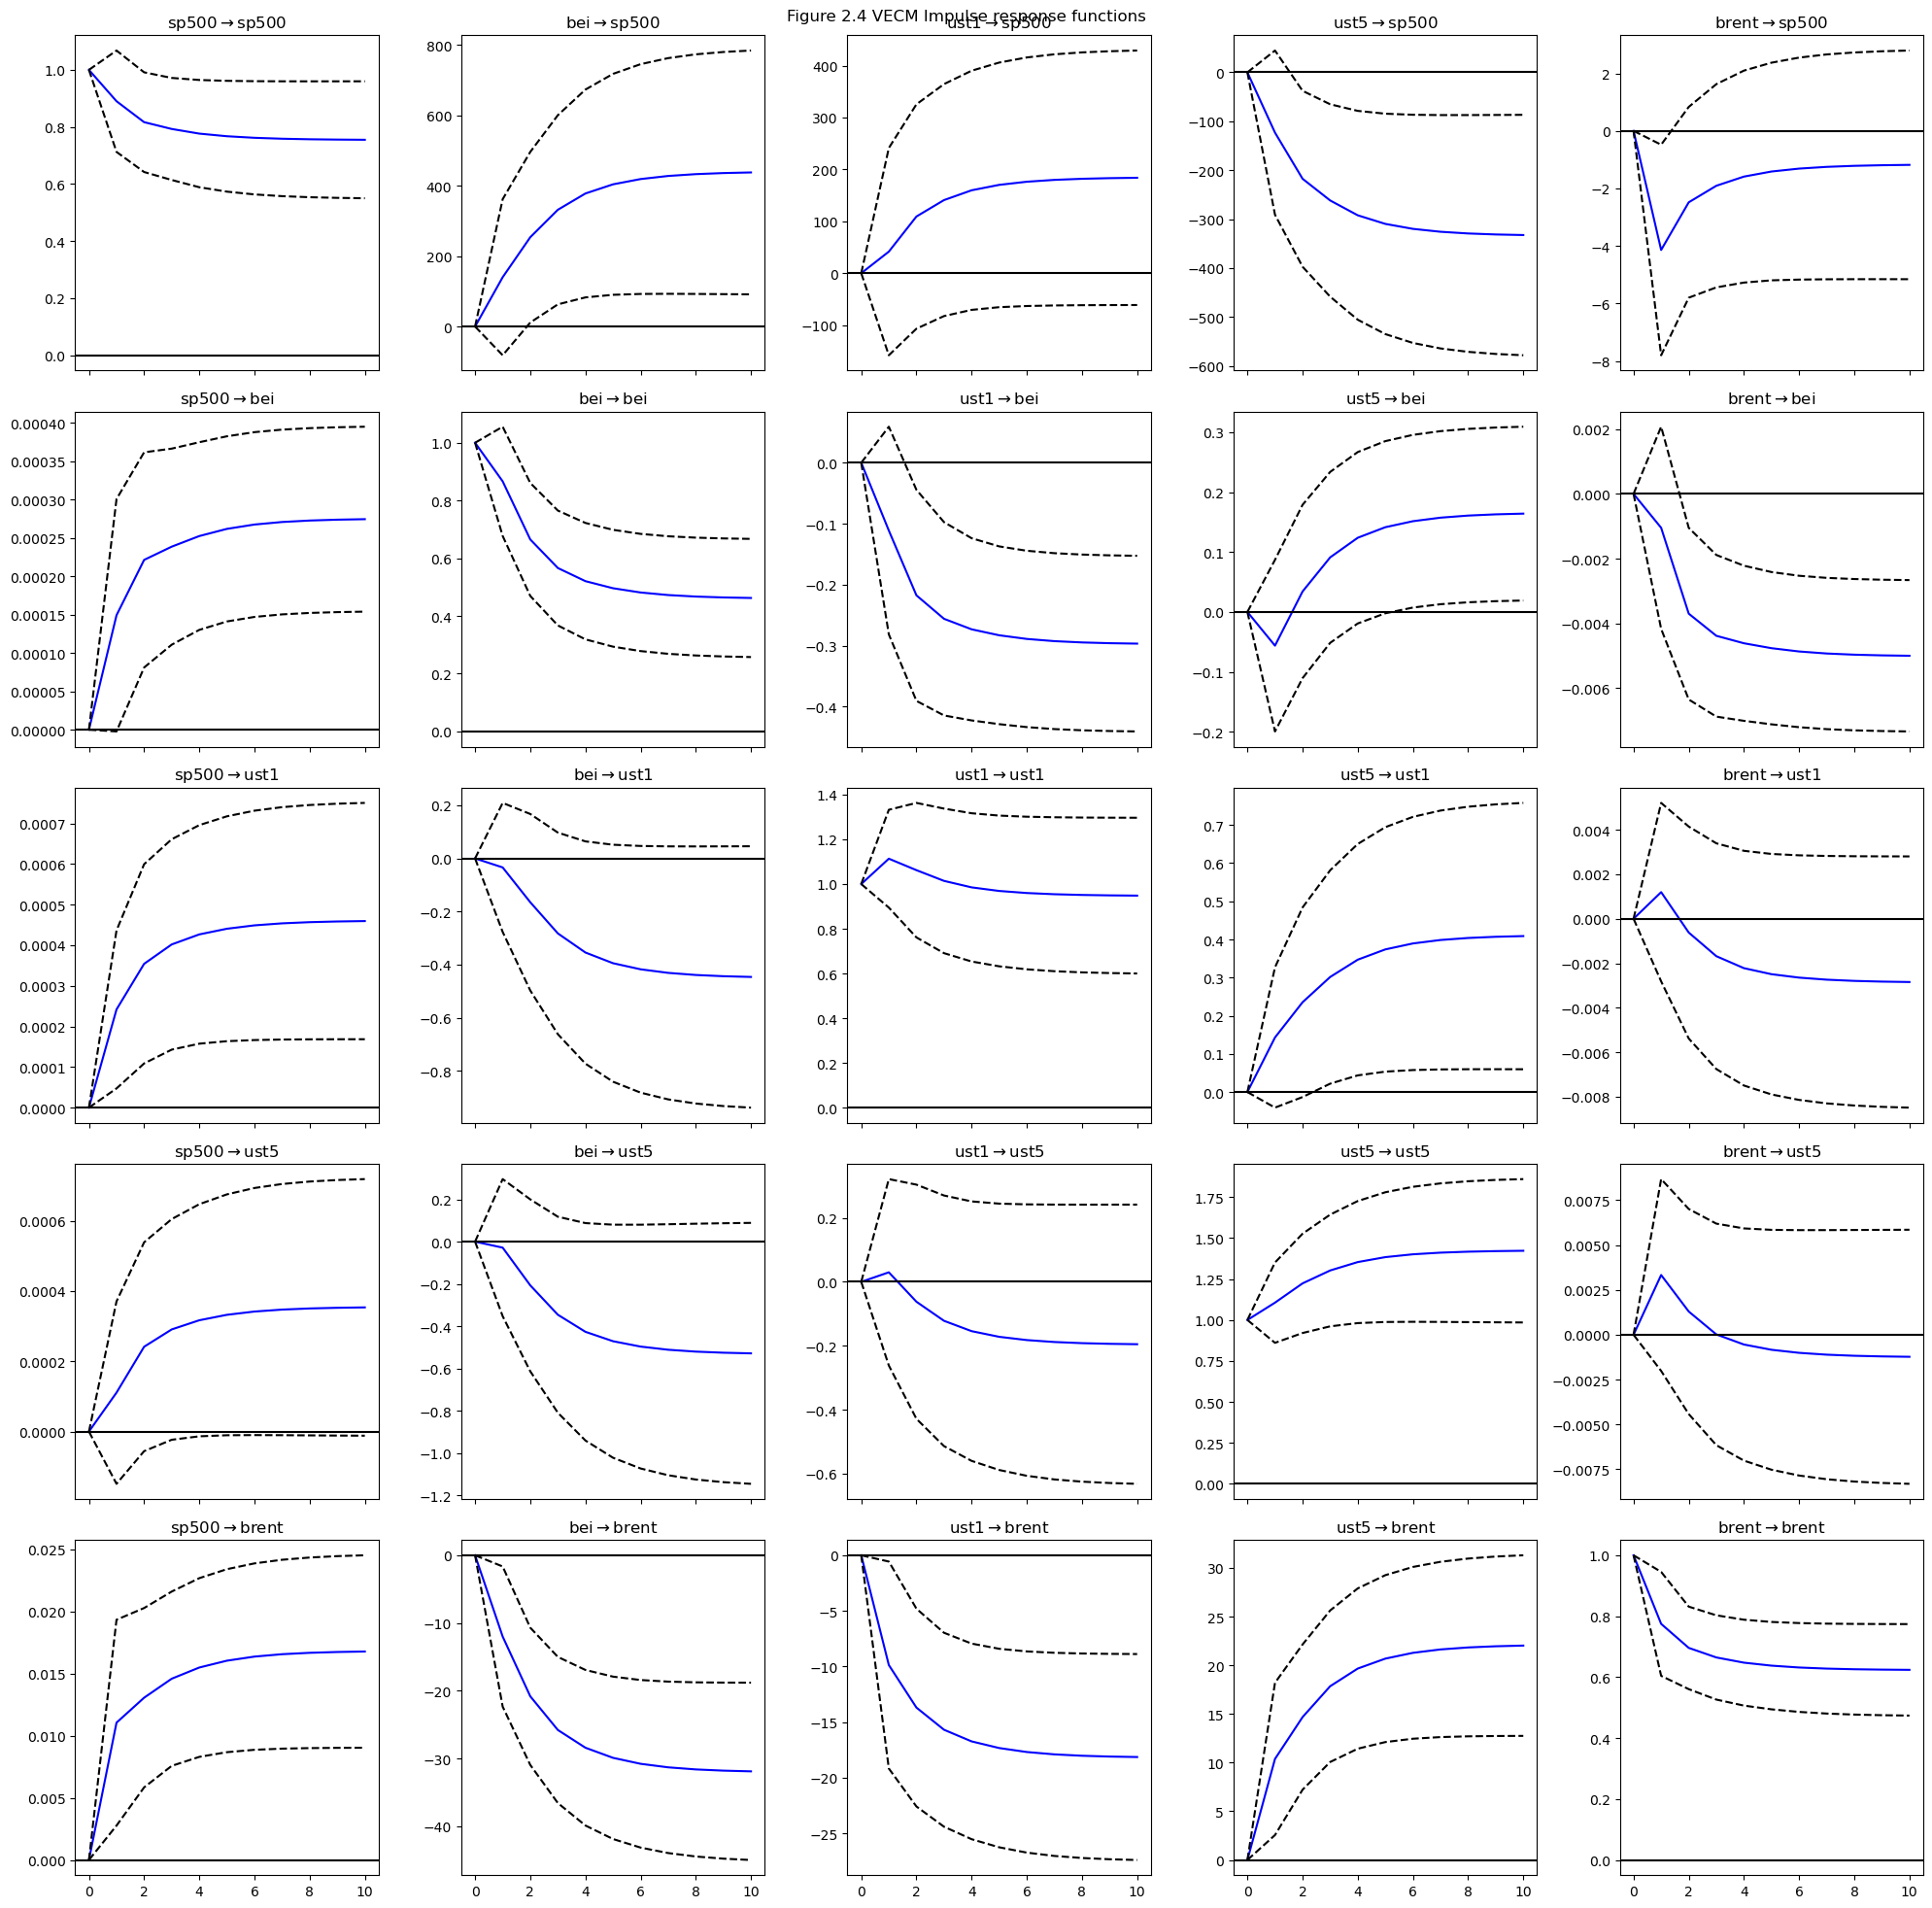

In [46]:
fig = vecm.irf().plot(figsize=(20, 20))
fig.suptitle('Figure 2.4 VECM Impulse response functions')
fig.tight_layout()

Specification tests can be executed to assess the relationships identified by the VECM. We estimated the Granger Causality p-values for the variables above with the VAR in levels. Brent shows a large response away from 0 when ust5 is shocked, so we perform the Granger causality test on ust5 causing brent. The p-value is 0.07, larger than the 95% confidence acceptable value of 0.05, meaning we fail to reject the null hypothesis that ust5 does not Granger-cause brent.

In [47]:
granger_results = vecm.test_granger_causality(caused="brent", causing='ust5', signif=0.05)
print(granger_results.summary())

Granger causality F-test. H_0: ust5 does not Granger-cause brent. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.665          3.010   0.070 (2, 610)
----------------------------------------------


The White test is also estimated. The White test is a test that examines whether there is constant variance in the errors: whether they are homoskedastic. The White test rejects the null that there is no autocorrelation in the VECM residuals. The residual's autocorrelogram is also plotted below. Autocorrelation in teh VECM residuals suggests an improperly specified model.

In [48]:
white_test = vecm.test_whiteness(nlags=12, adjusted=True)
print(white_test.summary())

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         379.3          309.3   0.000 270
-----------------------------------------


In [49]:
from statsmodels.tsa.api import VECM
from statsmodels.stats.diagnostic import acorr_lm
import numpy as np

lag_order = max(varL_order.bic, 1)
vecm = VECM(vecm_data.drop(cols_is_crisis, axis=1),
            exog=vecm_data[cols_is_crisis], 
            k_ar_diff=lag_order, 
            coint_rank=jtest.rank).fit()
residuals = vecm.resid.flatten()
lm_test_statistic, lm_p_value, f_test_statistic, f_p_value = acorr_lm(residuals)
print(f"Lagrange Multiplier Test for Residual Autocorrelation:")
print(f"LM Test Statistic: {lm_test_statistic}")
print(f"LM Test P-Value: {lm_p_value}")
print(f"F Test Statistic: {f_test_statistic}")
print(f"F Test P-Value: {f_p_value}")


Lagrange Multiplier Test for Residual Autocorrelation:
LM Test Statistic: 0.04980547032531257
LM Test P-Value: 0.9999999999218293
F Test Statistic: 0.004901500806729227
F Test P-Value: 0.999999999925689


The Lagrange Multiplier test is also estimated with a similar null to the White test: no autocorrelation in the residuals. The p-value is very close to 1.0, indicating that there is no significant evidence to reject the null hypothesis of no residual autocorrelation, supporting the test results of the White test.

Figure X shows the autocorellograms of the residuals of the VECM equations. Any ACF coefficients that depart the indicated 95% confidence boundary are statistically different from 0 (we reject the null that that are 0). Most are indeed within the boundary, but there are some that escape.

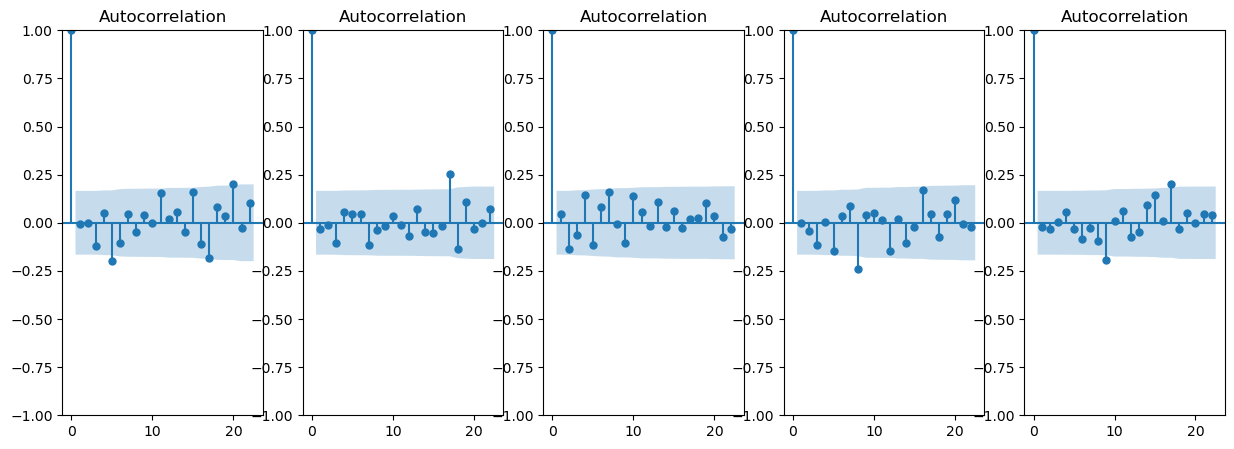

In [50]:
fig, axes = plt.subplots(1, vecm.resid.shape[1], figsize=(15, 5))
for idx, ax in enumerate(axes.ravel()):
    plot_acf(vecm.resid[:, idx], ax=ax)

### VAR with first differences

We now turn to the first differences of the I(1) series. Differencing the series makes them stationary as we showed with the ADF unit root tests above. We showed that we can reject the presence of a unit root with >99% confidence for the first-differenced series.

In [51]:
var_data = data_diff.copy()
columns_to_drop = ['ust5_cyc', 'ust1_cyc']
var_data = var_data.drop(columns=columns_to_drop)

Selecting the order of the VAR with first-differences follows the same procedure as above. Surprisingly, the information crieria are very similar. AIC, BIC, FPE and HQIC all recommend a lag order of 0 again. We move forward and estimate a VAR in first-differences with 1 lag.

In [52]:
varL_order = select_order(var_data.dropna().values, maxlags=10, deterministic='ci')
varL_order.summary()

,AIC,BIC,FPE,HQIC
0,-1.645*,-0.8527*,0.1932*,-1.323*
1,-1.502,-0.1442,0.2234,-0.9503
2,-1.401,0.5223,0.2485,-0.6196
3,-1.245,1.244,0.2932,-0.2343
4,-1.056,1.998,0.3599,0.1845
5,-1.281,2.339,0.2944,0.1897
6,-1.274,2.912,0.3065,0.4266
7,-1.177,3.575,0.3532,0.7537
8,-1.206,4.111,0.3635,0.9542
9,-1.243,4.640,0.3775,1.147


In [53]:
var = VAR(var_data.dropna()).fit()

In [54]:
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Dec, 2023
Time:                     11:05:51
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -1.31233
Nobs:                     135.000    HQIC:                  -1.69559
Log likelihood:          -795.622    FPE:                   0.141189
AIC:                     -1.95795    Det(Omega_mle):        0.113599
--------------------------------------------------------------------
Results for equation sp500
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            4.037418         8.615669            0.469           0.639
L1.sp500        -0.088713         0.092637           -0.958           0.338
L1.bei         144.298210       112.095789            1.287           0.198
L1.u

The VAR with first differences is estimated with the table in the appendix. Few of the p-values on the coefficients are significant but some are. the first lag of the first-differenced brent oil price has a significant effect on the log returns of the S&P500. The coefficient is negative, as one would expect, so an increase in the oil price (granger) causes a fall in the log returns of the S&P500. This is an effect that makes sense, because oil is a key input for many large manufacturing firms, and we say in the Asset Pricing project how stock indexes are linked to the risk in oil prices. The first lag of the differenced 1-year maturity also (granger) causes a change (in the opposite direction because the coefficient is negative) in the first differenced brent oil prices. We are slightly more cynical about this result because the links are far less clear cut but the coefficient suggests increasing yield decreases oil prices. Perhaps the treasury yield can be linked to monetary policy curbing inflation of oil prices, but we can be sceptical about this because BEI has not got a significant effect on brent.

The impulse responses reflect the VAR results. Two of the responses are statistically significant from 0. We focus on the variables for which we found pariwise granger causality; namely brent on S&P500 and ust1 on brent. A shock to brent does cause a response in the S&P500 statistically significant from 0. A negative shock as we would expect, but the S&P500's first differences recover and the effect diminishes to 0 over time. For ust1 on brent the effect is slightly less significant. This is the only other statistically significant response and brent behaves as we would expect. Increasing 1-year maturity yields causes decreasing oil prices, but the oil price first differences also return to 0 in a fairly short period of time.

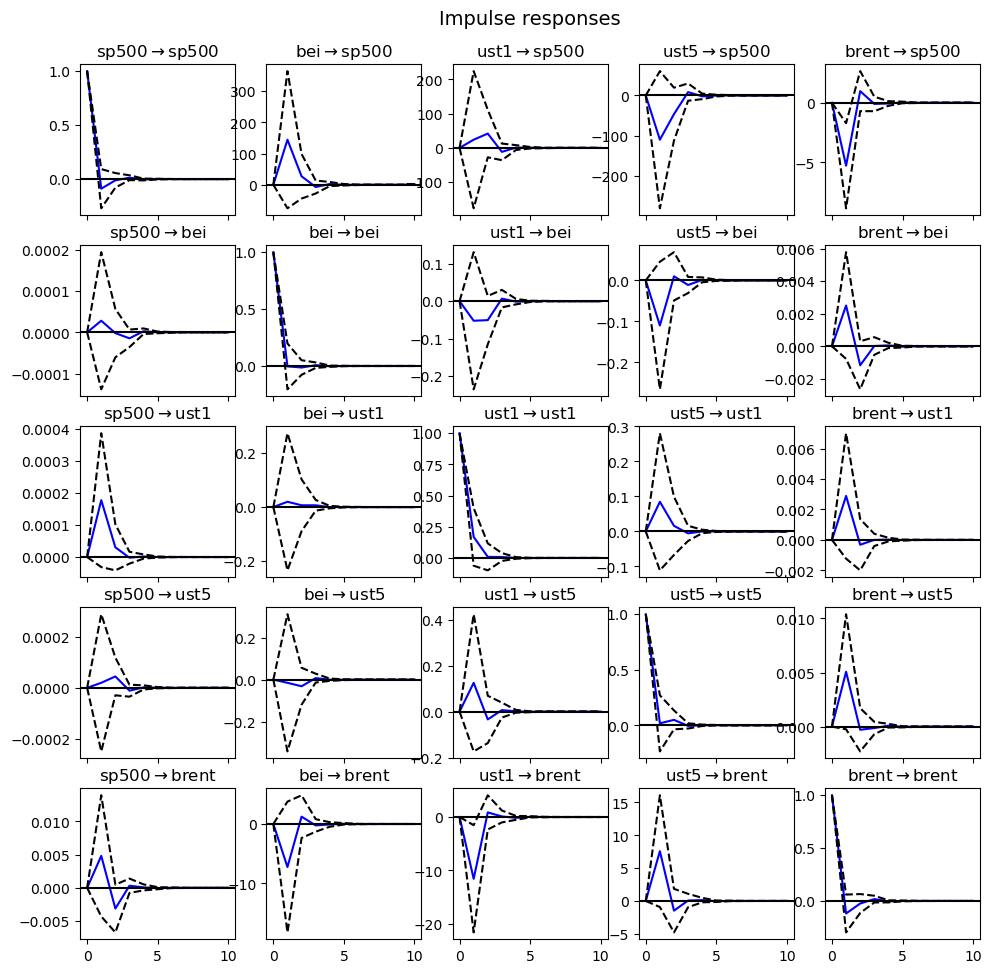

In [55]:
var.irf().plot();

In [56]:
gtest = var.test_causality('bei', causing='sp500')
print(gtest.summary())

Granger causality F-test. H_0: sp500 does not Granger-cause bei. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.1092          3.856   0.741 (1, 645)
----------------------------------------------


In [57]:
gtest = var.test_causality('sp500', causing='brent')
print(gtest.summary())

Granger causality F-test. H_0: brent does not Granger-cause sp500. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         8.404          3.856   0.004 (1, 645)
----------------------------------------------


In [58]:
gtest = var.test_causality('brent', causing='ust1')
print(gtest.summary())

Granger causality F-test. H_0: ust1 does not Granger-cause brent. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         5.101          3.856   0.024 (1, 645)
----------------------------------------------


# compare the results you obtain when you invert the VAR


To summarise, we have confirmed the existence of cointegrating relationships between the variables in levels. We have estimated a VAR in levels and IRFs, a VECM 'in levels' and IRFs and a VAR with first differences and IRFs in that order. The VAR in levels suffered from severe misspecification. Few of the coefficients had statistically significant coefficients and the IRFs rarely had confidence intervals that did not emcompass the y=0 line, indicating the response was not statistically significant from 0. For the VECM, we acknowledged the cointegrating relationships and estimated the VAR with error correction mechanisms. The IRFs reflected this well, showing shocks on the variables diminishing over time as the time series returned to their 'long-run' equilibrium values (the error correction mechanism at work). There were also fewer cases where the confidence interval enveloped the y=0 line, so the responses had a higher incidence of being statistically significant. So far, the VECM model has been the best, which is what is expected given that we confirmed at three cointegrating relationships using the trace test. Neverhteless, there was still autocorrelation present in the residuals. Finally, the VAR with first differenced time series was estimated. We showed that the time series in levels was non-stationary (I(1)) and subsequently showed that the first differences were weakly stationary (I(0)) making them suitable for a VAR. We did confirm pairwise granger causality for some of the variables and this was reflected in the impulse response functions. Most impulse response functions had confidence intervals that failed to depart from the y=0 line, but shocks to the variables that Granger cause others did. Overall, the best performing model was the VECM, It fitted the data best and the impulse response functions were the most informative. The cointegration of the variables was accounted for and the model was strong comparably.

# Application 4 SVAR

This section sees us implement a structural VAR model for the series Brent, 1-year maturity bond yield and the break-even inflation rate, a selection of the series utilised in the prior sections. The Structural VAR was developed by Sims (1980) and provides insight into the forecast errors in the VAR model. He hypothesised that these errors were because of shocks that had well defined sources lik eoil price shocks or interest rate shocks. Sims located the sources of the shocks that the VAR errors consist of and estimated the dynamic causal effects of the shocks (Stock & Watson, 2020).

The SVAR allows better insight into the causal influences in the model. Our model is a short-run SVAR without exogenous variables:
$$
A(I_k-A_1L-A_2L^2-A_3L^3)y_t=Aε_t=Bε_t
$$
Where we have one lag of the variables using the lag operator $L$. $A$, $B$ and $A_i$ $i=1, 2, 3$ are $3x3$ matrixes of parameters, $ε_t$ is a $3x1$ matrix of innovations with $ε_t ~ Ν(0,Σ)$ $Σ=L•L'$ where $L$ is the lower triangular matrix (put first exogenous variables then endogenous). The shocks are orthogonal so $E[ε_tε_t']=0_K$. We obtain identification by placing restrictions on $A$ and $B$.

The Cholesky decomposition is a method for identifying the IRF for the SVAR. It imposes $A$ as the lower triangular matrix with ones on the diagonal and $B$ as a diagonal matrix. The estimate $\hat{P_{sr}}=\tilde{A^{-1}}\tilde{B}$ should equal the Cholesky decomposition of $\hat{Σ}$ (Stata, 2023).

The restrictions on the shocks are specified as follows and are justified by our findings of causality in the VAR and VECM models we estimated above. Brent has a contemporaneous effect on itself but not on the other variables. ust1 has a contemporaneous effect on itself and on the brent oil pricing. the break-even inflation, BEI, has a contemporaneous effect on itself, brent and ust1. The variables are ordered in this way from most exogenous (brent) to most endogenous (BEI). 

In [59]:
week_data.head()

,sp500,bei,ust1,ust5,brent
date,,,,,
2021-01-01,NaN,NaN,NaN,NaN,NaN
2021-01-08,3824.679932,2.06,0.1,0.49,55.51
2021-01-15,3768.250000,2.10,0.1,0.46,54.80
2021-01-22,3841.469971,2.09,0.1,0.44,55.22
2021-01-29,3714.239990,2.13,0.1,0.45,55.25


In [64]:
var_data = data_diff[['brent', 'ust1', 'bei']].copy()

In [65]:
varL_order = select_order(var_data.dropna().values, maxlags=5, deterministic='ci')
varL_order.summary()

,AIC,BIC,FPE,HQIC
0,-6.156*,-5.826*,0.002120*,-6.022*
1,-6.079,-5.550,0.002292,-5.864
2,-6.037,-5.309,0.002392,-5.741
3,-6.012,-5.085,0.002456,-5.635
4,-5.975,-4.850,0.002552,-5.518
5,-5.993,-4.669,0.002515,-5.455


In [61]:
var_data

,brent,ust1,bei
date,,,
2021-01-01,NaN,NaN,NaN
2021-01-08,NaN,NaN,NaN
2021-01-15,-0.71,0.00,0.04
2021-01-22,0.42,0.00,-0.01
2021-01-29,0.03,0.00,0.04
...,...,...,...
2023-09-29,1.87,0.00,-0.02
2023-10-06,-8.00,-0.03,-0.04
2023-10-13,6.47,-0.02,0.03


In [62]:
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels import datasets

''

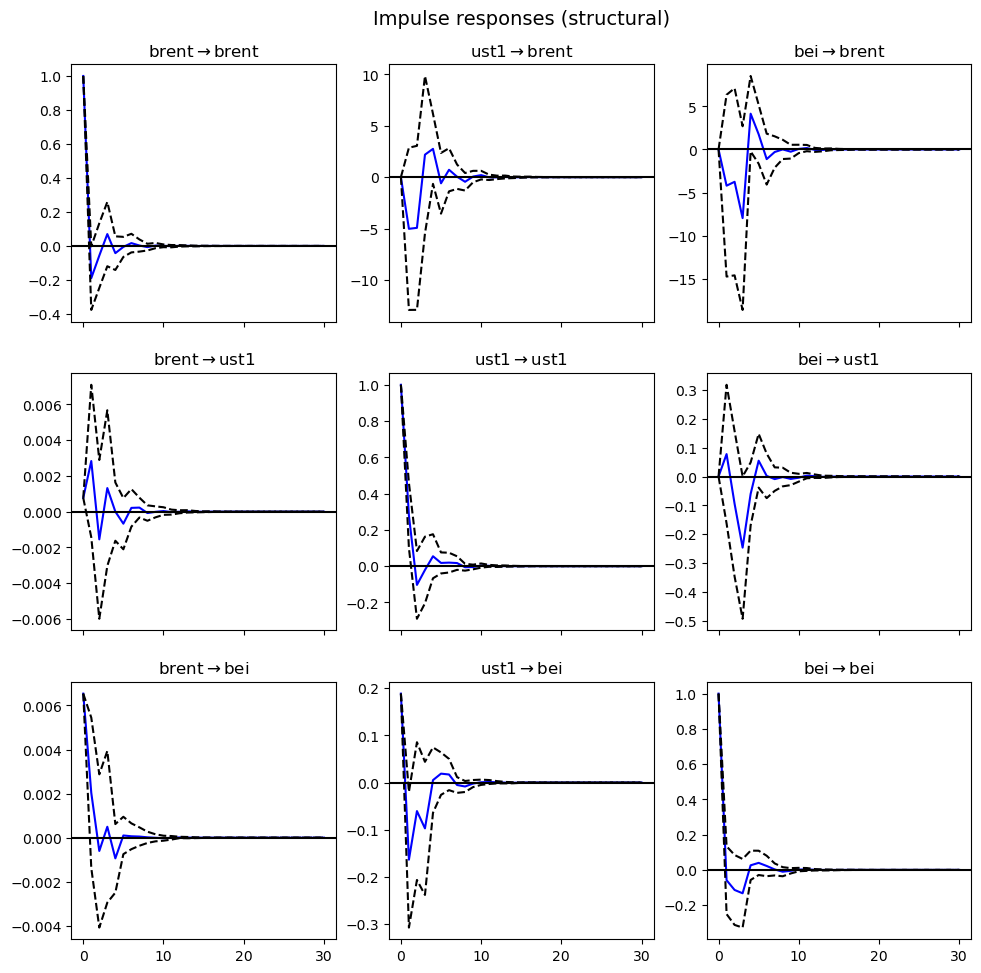

In [63]:
#define structural inputs
A = np.asarray([[1, 0, 0],['E', 1, 0],['E', 'E', 1]])
B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])
A_guess = np.asarray([0.5, 0.25, -0.38])
B_guess = np.asarray([0.5, 0.1, 0.05])
mymodel = SVAR(var_data.dropna(), svar_type='A', A=A) # B=B)
res = mymodel.fit(maxlags=3, maxiter=10000, maxfun=10000, solver='bfgs')
res.irf(periods=30).plot() 
# impulse='sp500', plot_stderr=True, stderr_type='mc', repl=100)
;

The impulse responses are shown in Figure X. All responses show a convergence back to the y=0 line. The SVAR also suffers from the lack of significance of the repsonses with most of the confidence intervals  encompassing the y=0. Some of the responses are statistically significant from 0 initially however. For example, a shock to the oil prices causes an initial increase in the 1-year maturity bond yield. This could be a monetary policy response. We also saw above how a posiitve shock to the oil prices causes a decline in the S&P500, and it seems the price of the bond declines also, contributing to the increase in yield. The shock to brent also contributes to the BEI. The BEI shows the expectation of inflation, so as the oil price increases, the market's expectation of inflation also increases. The opposite is the effect of a shock to ust1 on BEI. A decline in the yield of the 1-year maturity bond contributes to a fall in the BEI, meaning inflationary expectation has decreased.

# References

Brooks, C., 2019. Introductory econometrics for finance. Cambridge university press.

Ljung, G.M. and Box, G.E., 1978. On a measure of lack of fit in time series models. Biometrika, 65(2), pp.297-303.

Sims, C.A., 1980. Macroeconomics and reality. Econometrica: journal of the Econometric Society, pp.1-48.

Stata (2023) Var svar — structural vector autoregressive models - stata. Available at: https://www.stata.com/manuals/tsvarsvar.pdf (Accessed: 11 December 2023). 

Stock, J.H. and Watson, M.W., 2020. Introduction to econometrics. Pearson.

Tsay, R.S., 2005. Analysis of financial time series. John wiley & sons.